Projecting MODIS (MxD11_L2) LST data

In [7]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate

%matplotlib inline

Load a single HDF file as an xarray dataset

In [73]:
f_path = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MODIS\Tuolumne_2017_MxD11_L2\MYD11_L2.A2017112.1005.006.2017114012041.hdf'
f = xr.open_dataset(f_path)

Inspect the dataset

In [74]:
f

<xarray.Dataset>
Dimensions:     (Along_swath_lines_1km:MOD_Swath_LST: 2040, Coarse_swath_lines_5km:MOD_Swath_LST: 408, Coarse_swath_pixels_5km:MOD_Swath_LST: 271, Cross_swath_pixels_1km:MOD_Swath_LST: 1354)
Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_LST, Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST
Data variables:
    Latitude    (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 ...
    Longitude   (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 ...
    LST         (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) float32 ...
    QC          (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) uint16 ...
    Error_LST   (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) float32 ...
    Emis_31     (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixe

Plot the land surface temperature SDS data variable

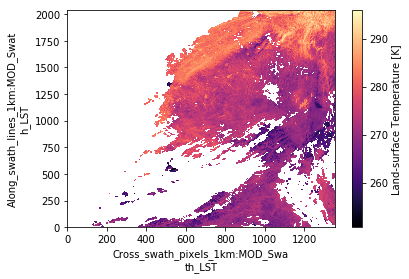

In [75]:
f.LST.plot(cmap='magma')

Define a function to interpolate from the coarse resolution latitude and longitude to the same resolution as the LST SDS

In [90]:
def interpLatLon(ds):
    '''Given a MODIS (MxD11_L2) xarray.Dataset (ds), interpolate between arrays of Latitude and Longitude values.
       Return a dataset with Lat/Lon arrays of the correct size to match the LST SDS.'''
    
    x = ds['Coarse_swath_pixels_5km:MOD_Swath_LST'].values # swath pixels, along-track (x values)
    y = ds['Coarse_swath_lines_5km:MOD_Swath_LST'].values # swath lines, cross-track (y values)
    xx, yy = np.meshgrid(x, y) # Create meshgrid of pixel/line values
    
    # Create pixel/line coordinates for between the coarse pixels (1/scale_factor)
    scale_factor = 5
    step = 1 / scale_factor
    offset = 2
    xnew = np.arange(0-(offset*step), f['Coarse_swath_pixels_5km:MOD_Swath_LST'].shape[0]-(offset*step), step)
    ynew = np.arange(0-(offset*step), f['Coarse_swath_lines_5km:MOD_Swath_LST'].shape[0]-(offset*step), step)
    
    # Interpolate within the Latitude array
    z_lat = ds.Latitude.values
    fn_lat = interpolate.interp2d(x, y, z_lat, kind='linear')
    znew_lat = fn_lat(xnew, ynew)
    if znew_lat.shape[1] > ds.LST.shape[1]: # if our interpolated Latitude array is longer than the LST SDS
        znew_lat = znew_lat[:,0:ds.LST.shape[1]] # make it them same shape
    # Add new Latitudes to MODIS dataset
    lat = xr.DataArray(znew_lat, dims=['Along_swath_lines_1km:MOD_Swath_LST', 'Cross_swath_pixels_1km:MOD_Swath_LST'])
    ds['Latitude_1km'] = lat
    
    # Interpolate within the Longitude array
    z_lon = ds.Longitude.values
    fn_lon = interpolate.interp2d(x, y, z_lon, kind='linear')
    znew_lon = fn_lon(xnew, ynew)
    if znew_lon.shape[1] > ds.LST.shape[1]: # if our interpolated Longitude array is longer than the LST SDS
        znew_lon = znew_lon[:,0:ds.LST.shape[1]] # make it them same shape
    # Add new Longitudes to MODIS dataset
    lon = xr.DataArray(znew_lon, dims=['Along_swath_lines_1km:MOD_Swath_LST', 'Cross_swath_pixels_1km:MOD_Swath_LST'])
    ds['Longitude_1km'] = lon
    
    # Set coordinates to the newly interpolated Lat and Lon values
    #ds.reset_coords(drop=True)
    ds = ds.set_coords(['Longitude_1km', 'Latitude_1km'])
    
    return ds

Create a new dataset with this function, with the newly interpolated Latitude and Longitude values

In [95]:
f_new = interpLatLon(f)
f_new

<xarray.Dataset>
Dimensions:        (Along_swath_lines_1km:MOD_Swath_LST: 2040, Coarse_swath_lines_5km:MOD_Swath_LST: 408, Coarse_swath_pixels_5km:MOD_Swath_LST: 271, Cross_swath_pixels_1km:MOD_Swath_LST: 1354)
Coordinates:
    Latitude_1km   (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) float64 54.03 ... 32.44
    Longitude_1km  (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) float64 -134.0 ... -110.8
Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_LST, Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST
Data variables:
    Latitude       (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 54.027428 ... 32.435116
    Longitude      (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 -133.96289 ... -110.763054
    LST            (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_

Plot the LST SDS on a Latitude/Longitude grid

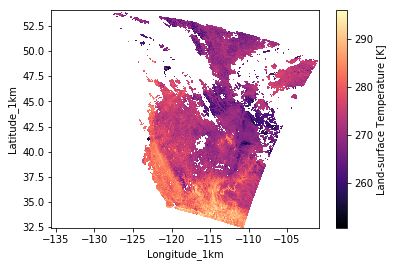

In [88]:
f_new.LST.plot(x='Longitude_1km',y='Latitude_1km',cmap='magma')

Find the LST value for a pixel at a specific location specified by a latitude and longitude

In [85]:
lat_obs = 37.89
long_obs=-119.32
coordinates = np.unravel_index((np.abs(f.Latitude_1km - lat_obs) + np.abs(f.Longitude_1km - long_obs)).argmin(), f.Latitude_1km.shape)
f_new.LST[coordinates]

<xarray.DataArray 'LST' ()>
array(270.12, dtype=float32)
Coordinates:
    Latitude_1km   float64 37.89
    Longitude_1km  float64 -119.3
Attributes:
    long_name:         Land-surface Temperature
    units:             K
    Number Type:       uint16
    valid_range:       [ 7500 65535]
    LST:               LST data * scale_factor
    scale_factor_err:  0.0
    add_offset_err:    0.0
    calibrated_nt:     5

Plot the location of this pizel we retrieved the value from

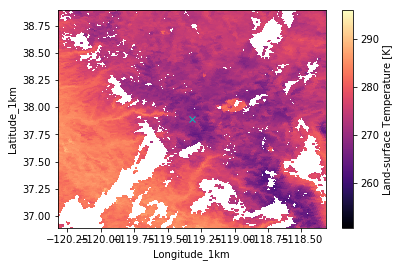

In [94]:
f_new.LST.plot(x='Longitude_1km',y='Latitude_1km',cmap='magma')
plt.xlim((long_obs-1,long_obs+1))
plt.ylim((lat_obs-1,lat_obs+1))
plt.plot(long_obs,lat_obs,'cx')